In [ ]:
#If you want to obtain the results for the entanglement switched on, please set default for entanglement parameter to 1. 

In [165]:
#Making "from qencode.encoders import e1_classic" work in the jupyter notebook
import sys
import os
sys.path.insert(0, '../')

#importing libraries
import pennylane as qml
import torch
from torchvision import datasets, transforms
import argparse
from scipy.linalg import sqrtm
from pennylane import numpy as np
from tqdm import tqdm
from torch.utils.data import RandomSampler, SubsetRandomSampler

#importing defined functions from the repository
from qencode.encoders import e1_classic

In [166]:
#Defining arguments 
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=10)
parser.add_argument('--img_width', default=4)
parser.add_argument('--img_height', default=4)
parser.add_argument('--nr_batches_per_epoch', default=5)
parser.add_argument('--entanglement', default=1) #0 = no entanglement, 1= entanglement assisted

#args = parser.parse_args()       # running not in notebook
args = parser.parse_args(args=[]) # running in notebook 

In [167]:
#Importing MNIST dataset
def get_dataset(img_width, img_height, train):
    trainset = datasets.MNIST(root='./dataset', train=train, download=True,
                              transform=transforms.Compose(
                                  [transforms.Resize((img_width, img_height)), transforms.ToTensor()])
                              )
    return trainset

#Creating train and test datasets
train_loader = torch.utils.data.DataLoader(get_dataset(args.img_width, args.img_height, train=True), \
                                           batch_size=args.batch_size, sampler=RandomSampler(get_dataset(args.img_width, args.img_height, train=True), replacement=True, num_samples=args.nr_batches_per_epoch*args.batch_size))
test_loader = torch.utils.data.DataLoader(get_dataset(args.img_width, args.img_height, train=False), batch_size=1, sampler = SubsetRandomSampler([i for i in range(1000)]))

In [168]:
#defining number of qubits (distinguishing the case with and without entanglement)

wires=[0,1,2,3,4,5,6,7] #data_qubits = 1,2,3,4; ref_qubits = 5,6,7;

#setting up a quantum device 
dev = qml.device("default.qubit", wires=wires)
shots = 1024

In [169]:
#defining the Quantum Auto Encoder circuit with and without entanglement
@qml.qnode(dev)
def QAE(inputs,encoder_params,do_what): 
#do_what=0 train;do_what=1 return the density matrix of initial state; do_what=2 return the density matrix of the decoded state
    
    #Prepare entanglement
    if args.entanglement == 1:
        
        #Ladder of CNOT connecting trash qubits and reference qubits - latent space does not get entangled here
        qml.Hadamard(wires=1)
        qml.Hadamard(wires=2)
        qml.Hadamard(wires=3)
        qml.PauliX(wires=5)
        qml.PauliX(wires=6)
        qml.PauliX(wires=7)
        qml.CNOT(wires=[1,5])
        qml.CNOT(wires=[2,6])
        qml.CNOT(wires=[3,7])


    
    #INITIALIZATION:
    #Encode a picture using Amplitude Embedding
    qml.AmplitudeEmbedding(inputs, wires=[1,2,3,4],normalize=True)
    
    #Encode a picture using Angle Embedding
    """
    qml.templates.embeddings.AngleEmbedding(
        inputs, wires=[1,2,3,4], rotation="X"
    )
    """
    if do_what==1:
        return qml.density_matrix([1,2,3,4])
    

    #Reference qubits require no preparation
    
    #ENCODER
    e1_classic(encoder_params,[1,2,3,4]) 
        
    #OUTPUT for training
    if do_what==0:  
        #SWAP TEST
        qml.Hadamard(0)
        qml.CSWAP(wires=[0,1,7])
        qml.CSWAP(wires=[0,2,5])
        qml.CSWAP(wires=[0,3,6])
        qml.Hadamard(0)
                
        return qml.probs(wires=[0])
    
        
    if do_what==3:

        return qml.density_matrix(wires=[1,5])
        return qml.probs(wires=[5])

    #DECODER
    qml.adjoint(e1_classic)(encoder_params, [7,5,6,4])
        
    return qml.density_matrix([7,5,6,4])   

In [170]:
#Calculating the number of parameters in the encoder
nr_qubits_encoder = 4  
nr_par_encoder = 2 * 3 * nr_qubits_encoder + 3 * (nr_qubits_encoder - 1) * nr_qubits_encoder

In [171]:
#Defining the loss function
def loss_function(datapoint, params):
    circuit_output =  QAE(datapoint,params,0)
    p0_1st_SWAP=circuit_output[0]
    return 2*(1 - p0_1st_SWAP)

In [172]:
#Initializing parameters
params = np.random.normal(size=(nr_par_encoder), requires_grad=True)

In [173]:
#Optimizing the parameters of the encoder 
opt = qml.AdamOptimizer()
epochs = 100

#Cost function - Imposing fidelity=1 for the trash and reference qubits
def cost(params, batch):
    loss = 0.0
    for datapoint in batch:
        loss += loss_function(datapoint, params)
    return loss / batch.shape[0]

In [174]:
#Running the training
for i in range(epochs):
    print(f'Epoch {i}')
    loss = 0
    for batch, y in tqdm(train_loader):
        batch = batch.reshape(-1, args.img_height*args.img_width)
        loss += cost(params,batch)
        params = opt.step(cost, params, batch=batch)
    print(loss / args.nr_batches_per_epoch)
    

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


0.9270732389685851
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.8351258155011434
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


0.7521023421888813
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


0.7121381968186709
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


0.6552270315311727
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


0.6242394940315361
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


0.5955557341998491
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


0.5879649596100404
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


0.5518476392952503
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


0.5245895028299304
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


0.5372156379463542
Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


0.5092942170088216
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.25it/s]


0.49417192221609624
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


0.5039132282567426
Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.23it/s]


0.4927079541823539
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


0.4686037972065636
Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/it]


0.477188101223207
Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


0.4976034780802455
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


0.46834129755746357
Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


0.47304938375918393
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


0.453801204652663
Epoch 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


0.4669485501586923
Epoch 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.4399495776973302
Epoch 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.4465101887161625
Epoch 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.4123643622146367
Epoch 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


0.40210307851903887
Epoch 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


0.3948101136295308
Epoch 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.21it/s]


0.38189569136576845
Epoch 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.39899584558789536
Epoch 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


0.3921872170512839
Epoch 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.07s/it]


0.4011962389209775
Epoch 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


0.3467455077829076
Epoch 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


0.3290310791091921
Epoch 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


0.3580716254524792
Epoch 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


0.3336837356517603
Epoch 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


0.2874221022765003
Epoch 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25it/s]


0.27357485620660354
Epoch 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


0.2564893346003206
Epoch 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


0.22590113236203685
Epoch 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.23249799399885177
Epoch 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


0.22286654871738812
Epoch 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.20615022242809244
Epoch 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.21587290113383578
Epoch 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


0.18738936025408778
Epoch 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.17493364736729045
Epoch 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


0.17771072731694765
Epoch 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


0.14854544485585844
Epoch 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.16486734035313388
Epoch 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


0.15701258472760365
Epoch 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


0.16426124385658358
Epoch 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.13566798545108052
Epoch 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.13870703272860438
Epoch 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


0.1366161267086946
Epoch 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


0.12540165156060057
Epoch 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


0.12146686833393908
Epoch 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


0.12276235933110125
Epoch 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


0.12107941487727328
Epoch 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


0.10778122781757822
Epoch 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


0.1229209690450634
Epoch 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


0.0984751265386182
Epoch 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


0.1109116414053721
Epoch 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]


0.10409684360198121
Epoch 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


0.10157193155330926
Epoch 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


0.10238527268877265
Epoch 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


0.10276499595802806
Epoch 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


0.09597620178867236
Epoch 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.08258816538031176
Epoch 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.10547751320486823
Epoch 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


0.1045171438588757
Epoch 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


0.08957646467710492
Epoch 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


0.10106291192414599
Epoch 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


0.09236965994855365
Epoch 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]


0.09606909895240552
Epoch 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.09947933475110306
Epoch 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


0.08824998385009661
Epoch 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


0.09736709661446666
Epoch 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


0.07575750608021634
Epoch 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


0.07437900323863486
Epoch 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


0.0813115701895291
Epoch 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


0.08590316136935301
Epoch 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.09561762107960717
Epoch 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.07511786165394099
Epoch 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


0.0837361827135436
Epoch 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.08512031523525573
Epoch 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


0.07090322361318685
Epoch 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.23it/s]


0.07900107785874914
Epoch 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


0.0825064197415418
Epoch 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


0.07624950855349985
Epoch 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


0.07023749262748377
Epoch 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


0.0590919308455811
Epoch 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


0.08254957897888074
Epoch 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


0.07284018822063762
Epoch 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


0.06764076619345759
Epoch 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


0.07043069167913917
Epoch 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.06943953710223037
Epoch 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


0.0707244540867952
Epoch 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


0.07014714227336669
Epoch 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


0.07316507690028737
Epoch 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


0.052414997406415996
Epoch 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]

0.055283226970264145


In [175]:
#Evaluating the faithfulness of the Quantum Auto Encoder

def fidelity(rho, sigma):
    # Inputs rho and sigma are density matrices
    sqrt_sigma = sqrtm(sigma)
    fid = np.trace(sqrtm(sqrt_sigma @ rho @ sqrt_sigma))
    return fid.real

def evaluate_similarity(datapoint, params):
    state_before=QAE(datapoint, params, 1)
    state_after=QAE(datapoint, params, 2)
    return fidelity(state_before, state_after)

In [176]:
results = []
for batch, y in tqdm(test_loader):
    batch = batch.reshape(-1, args.img_height*args.img_width)
    results.append(evaluate_similarity(batch[0], params))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.44it/s]


In [176]:
results_ent = []
for batch, y in tqdm(test_loader):
    batch = batch.reshape(-1, args.img_height*args.img_width)
    results_ent.append(evaluate_similarity(batch[0], params))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.44it/s]


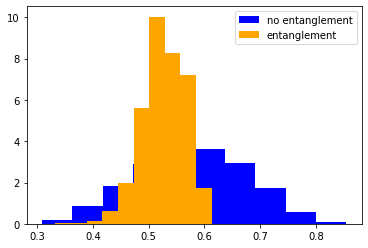

In [177]:
import matplotlib.pyplot as plt
plt.hist(results, density=True, color="blue", label="no entanglement")
plt.hist(results_ent, density=True, color="orange", label="entanglement")
plt.legend()
plt.show()

In [178]:
np.mean(results)

0.5763309003881876

In [179]:
np.mean(results_ent)

0.5273889879472251